# Basic Overview
This is a stab to see if Oscar's ideas listed as part of the comments [here](https://www.kaggle.com/aashita/xgboost-model-with-minimalistic-features) work.


Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Ha
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test_data_processed_correct.csv")

In [4]:
test_data.Survived.unique()

array([0., 1.])

Since XGBoost uses only numeric predictors, and we do not want to increase dimensionality, we will go with numeric encoding for sex and plcass variables for now.

In [5]:
train_data.loc[(train_data['Sex'] == 'male'), 'Sex'] = 1
train_data.loc[(train_data['Sex'] == 'female'), 'Sex'] = 0

test_data.loc[(test_data['Sex'] == 'male'), 'Sex'] = 1
test_data.loc[(test_data['Sex'] == 'female'), 'Sex'] = 0


In [6]:
# Add a column called Predictions in training data, which will become handy while doing
# cross validation.
train_data['Predictions'] = -1

In [7]:
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [8]:
def get_train_test_data(train_data,
                        X_columns=['Sex', 'Pclass', 'Age'], 
                        Y_columns=['Survived']):
    # Simple training and testing
    X = train_data[X_columns]
    Y = train_data[Y_columns]

    X_one_hot = pd.get_dummies(X)

    # Do imputation on relevant columns.
    X_train, X_test, Y_train, Y_test = train_test_split(X_one_hot, Y, random_state=0)

    return (X_train, X_test, Y_train, Y_test, X_one_hot, Y)


In [9]:
def create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators=100, 
                                            learning_rate=0.1):
    # Rewrite everything as a pipeline
    my_pipeline = make_pipeline(Imputer(), 
                                XGBClassifier(seed=1, n_estimators=n_estimators, learning_rate=learning_rate))
    my_pipeline.fit(X_train, Y_train.values.ravel())
    predictions = my_pipeline.predict(X_test)
    #predictions = (X_test['Sex'] == 0)
    out_of_sample_score = 1.0 - mean_absolute_error(predictions, Y_test)
    return (my_pipeline, out_of_sample_score, predictions)

In [10]:
def cross_validate(my_pipeline, X_one_hot, Y):
    cross_val_scores = cross_val_score(my_pipeline, X_one_hot, Y, scoring='neg_mean_absolute_error', cv=5)
    return 1.0  + cross_val_scores.mean()

In [11]:
def train_test_cross_validate(train_data, 
                              X_columns=['Sex', 'Pclass', 'Age'], 
                              Y_columns=['Survived'],
                              n_estimators=100,
                              learning_rate=0.1):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    my_pipeline, out_of_sample_score, predictions_test = \
        create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators, learning_rate)

    print("Number of entries in training set is {0}".format(len(X_train)))
    predictions_train = my_pipeline.predict(X_train)
    #predictions_train = (X_train['Sex'] == 0)    
    num_correct_predictions_train = int((1.0 - mean_absolute_error(predictions_train, Y_train)) * len(Y_train))


    print("Number of correct predictions in training set is {0}".format(num_correct_predictions_train))    
    print("Number of entries in test set is {0}".format(len(X_test)))    
    print("Number of correct predictions in test set is {0}".format(int(out_of_sample_score * len(X_test))))

    cross_validation_score = cross_validate(make_pipeline(Imputer(), 
                                                          XGBClassifier(seed=1,
                                                                        n_estimators=n_estimators, 
                                                                        learning_rate=learning_rate)), 
                                            X_one_hot, Y.values.ravel())
    return (my_pipeline, out_of_sample_score, cross_validation_score)

In [12]:
# Make sure that unnecessary deprecation warnings are avoided.
# Thanks to https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Correlation between predictors. 

In [13]:
train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr()

,Survived,Pclass,Age,Sex
Survived,1.000000,-0.338481,-0.077221,-0.543351
Pclass,-0.338481,1.000000,-0.369226,0.131900
Age,-0.077221,-0.369226,1.000000,0.093254
Sex,-0.543351,0.131900,0.093254,1.000000


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.heatmap(train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr(), ax=ax)

The correlation level looks acceptable here.

In [15]:
# Get the XGBclassifier directly as it is far easier to visualize this than the
# pipeline object.
def get_sklearn_xgbclassifier(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    my_model = XGBClassifier(seed=1)
    X_train = train_data[X_columns]
    Y_train = train_data[Y_columns]
    my_model.fit(X_train, Y_train.values.ravel())    
    return my_model

In [16]:
def get_gridsearch_crossval_output(train_data, 
                                   X_columns = ['Sex', 'Pclass'], 
                                   Y_columns = ['Survived'],
                                   n_estimators_list = [10, 50, 70, 100, 120, 150, 200],
                                   learning_rates_list = [0.01, 0.02, 0.05, 0.07, 0.1],
                                   early_stopping_round = 10,
                                   num_cross_val_sets = 5
                                  ):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    col_names = ['f' + str(i) for i in range(len(X_train.columns))]
    X_train.columns = col_names
    X_test.columns = col_names
    my_pipeline = Pipeline([('imputer', Imputer()), ('xgcl', XGBClassifier())])
    param_grid = {
        'xgcl__n_estimators' : n_estimators_list,
        'xgcl__learning_rate' : learning_rates_list
    }
    fit_params = {'xgcl__eval_set' : [(X_test, Y_test.values.ravel())],
                  'xgcl__early_stopping_rounds' : early_stopping_round,
                  'xgcl__verbose': False}

    searchCV = GridSearchCV(my_pipeline, cv=num_cross_val_sets, param_grid=param_grid, fit_params=fit_params)
    searchCV.fit(X_train, Y_train.values.ravel())
    return searchCV

In [17]:
def get_model_metrics_and_display(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    (my_pipeline, out_of_sample_score, cross_validation_score) = \
        train_test_cross_validate(train_data,
                                  X_columns, 
                                  Y_columns)

    print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))
    my_model = get_sklearn_xgbclassifier(train_data, X_columns, Y_columns)
    return my_model
    

### Idea 1:  Gender + Class + Embarked + Age yields a score of 0.78947


In [18]:
# Check for the values of Embarked variable.
train_data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [19]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predictions
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,-1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,-1


In [20]:
test_data[test_data['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived


In [21]:
# Remove the nans from the training data before analysis.
train_data_new = pd.get_dummies(train_data[train_data['Embarked'].notnull()])
test_data_new = pd.get_dummies(test_data[test_data['Embarked'].notnull()])

In [22]:
train_data_new.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Predictions', 'Name_Abbing, Mr. Anthony',
       ...
       'Cabin_F G73', 'Cabin_F2', 'Cabin_F33', 'Cabin_F38', 'Cabin_F4',
       'Cabin_G6', 'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object', length=1727)

Comment : It can be seen that since Embarked is a categorical variable, we will be forced to add in 2 variables (there are 3 values for this variable, hence we can represent this with 2 variables).

However, since we want to keep dimensonality as low as possible, we will try to see the 'density' of the values of this variable and check if we can manage with one variable itself.

In [23]:
train_data_new[['Embarked_C']].describe()

,Embarked_C
count,889.000000
mean,0.188976
std,0.391710
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [24]:
train_data_new[['Embarked_Q']].describe()

,Embarked_Q
count,889.000000
mean,0.086614
std,0.281427
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [25]:
train_data_new[['Embarked_S']].describe()

,Embarked_S
count,889.000000
mean,0.724409
std,0.447063
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Comments : It can be easily seen that 'S' is the major embarking point and hence let us use only that as our predictor for now(as far as 'Embarked' variable is concerned).

In [26]:
X_columns = ['Sex', 'Pclass', 'Age', 'Embarked_S']
Y_columns = ['Survived']

Number of entries in training set is 666
Number of correct predictions in training set is 576
Number of entries in test set is 223
Number of correct predictions in test set is 176
Out of sample score is 0.789237668161435
Cross val score is 0.823411413698978


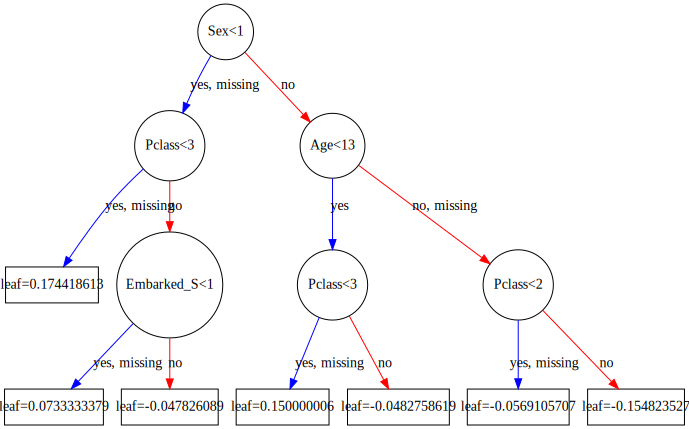

In [27]:
my_model = get_model_metrics_and_display(train_data_new,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comment : The performance does not look bad and asks for more tuning. Let us do it !

#### Fine tuning using xgboost cross validation


In [28]:
X_train = train_data_new[X_columns]
Y_train = train_data_new[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.01
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [29]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.193417,0.050409,0.138918,0.010581
1,0.193417,0.050409,0.138918,0.010581
2,0.193417,0.050409,0.138918,0.010581
3,0.193417,0.050409,0.138918,0.010581
4,0.193417,0.050409,0.137230,0.008463
5,0.193417,0.050409,0.136949,0.008738
6,0.193417,0.050409,0.137230,0.008463
7,0.193417,0.050409,0.136667,0.008590
8,0.193417,0.050409,0.136668,0.007977
9,0.188923,0.042843,0.136949,0.007582


#### Fine tuning using GridSearchCV


In [30]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [31]:
searchCV = get_gridsearch_crossval_output(train_data_new, X_columns=X_columns)
searchCV.best_params_


{'xgcl__learning_rate': 0.01, 'xgcl__n_estimators': 10}

In [32]:
searchCV.cv_results_['mean_train_score']

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.83821725, 0.83821725, 0.83821725, 0.83821725, 0.83821725,
       0.83821725, 0.83821725, 0.83821725, 0.83821725, 0.83821725,
       0.83821725, 0.83821725, 0.83821725, 0.83821725, 0.83821725,
       0.83859319, 0.83859319, 0.83859319, 0.83859319, 0.83859319,
       0.83859319, 0.83934507, 0.84009554, 0.84009554, 0.84009554,
       0.84009554, 0.84009554, 0.84009554, 0.8408446 , 0.84159648,
       0.84159648, 0.84159648, 0.84159648, 0.84159648, 0.84159648])

In [33]:
searchCV.cv_results_['mean_test_score']

array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83183183, 0.83183183, 0.83183183, 0.83183183, 0.83183183,
       0.83183183, 0.83183183, 0.83183183, 0.83183183, 0.83183183,
       0.83183183, 0.83183183, 0.83183183, 0.83183183, 0.83033033,
       0.83033033, 0.83033033, 0.83033033, 0.83033033, 0.83033033])

Comment : Both methods agree on this estimate, and hence let us go ahead and generate out of sample predictions using the same.

In [34]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data_new,
                              X_columns, 
                              Y_columns,
                              n_estimators=10,
                              learning_rate=0.01)
    
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 666
Number of correct predictions in training set is 557
Number of entries in test set is 223
Number of correct predictions in test set is 175
Out of sample score is 0.7847533632286996
Cross val score is 0.8076556846314987


Comment : The mystery continue, but let us generate out of sample predictions on kaggle test data !

In [35]:
X_columns

['Sex', 'Pclass', 'Age', 'Embarked_S']

In [36]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
Y_column = ['Survived']
X_train = train_data_new[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data_new[Y_column]
X_test = test_data_new[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data_new[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            10,
                                            0.01)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_sex_pclass_embarked.csv', index=False)

Complete score on out of sample data is 0.784688995215311


### Another model on Parch,SibSp, Embarked

We add another model using Parch,SibSp and Embarked factors which could prove useful in ensembling.

In [38]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
Y_column = ['Survived']
X_columns = ['Parch', 'SibSp', 'Embarked_S']
X_train = train_data_new[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data_new[Y_column]
X_test = test_data_new[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data_new[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_parch_sibsp_embarked.csv', index=False)

Complete score on out of sample data is 0.6770334928229664
